In [1]:
import ufl
from ufl import  TrialFunction, TestFunction, FacetNormal, lhs, rhs,SpatialCoordinate

import dolfinx
from dolfinx import mesh, fem, io
from dolfinx.fem import FunctionSpace, locate_dofs_geometrical, form
from dolfinx.fem.petsc import LinearProblem

from mpi4py import MPI
import petsc4py.PETSc
import numpy as np
import matplotlib.pyplot as plt


# Operators:
class Infix:

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = Infix(ufl.inner)
from ufl import dx, ds, grad, exp, div

npor = Infix(np.logical_or)
npand = Infix(np.logical_and)


# Classes:
def Function(space, func):
    """function function on new space

    Args:
        space (FunctionSpace): New space
        function (): Any function

    Returns:
        fem.Function: Function
    """

    if hasattr(func, 'ufl_domain'):
        func2 = func
    else:
        func2 = fem.Function(space)
        func2.interpolate(func)

    expr = fem.Expression(func2, space.element.interpolation_points())
    func2 = fem.Function(space)
    func2.interpolate(expr)
    return func2


def Constant(space, const):
    """Constant on space

    Args:
        space (FunctionSpace): Space
        const (auny number): Any number

    Returns:
        Constant: Constant on
    """
    return fem.Constant(space, petsc4py.PETSc.ScalarType(const))


def create_facet_markers(bound_markers, domain):
    """Mark facets under conditious

    Args:
        bound_markers (tuple): List of mark and function
        domain (Domain): Domain
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = mesh.locate_entities(
            domain,
            domain.topology.dim - 1,
            condition,
            )
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    facet_indices = np.hstack(facet_indices).astype(np.int64)
    facet_markers = np.hstack(facet_markers).astype(np.int64)
    sorted_facets = np.argsort(facet_indices)
    facet_tags = mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
        )

    return facet_tags


class BoundaryValue():

    def __init__(
        self,
        V,
        trial_func=None,
        test_func=None,
        ds = None,
        marked_facets=None,
        ):

        self.V = V
        self.domain = V.mesh
        self._marked_facets = marked_facets
        self._test_func = test_func
        self._trial_func = trial_func
        self._ds = ds

        self.domain.topology.create_connectivity(
            self.domain.topology.dim - 1,
            self.domain.topology.dim,
            )
        return

    def _get_exterior_facets(self):
        exterior_facets = mesh.exterior_facet_indices(self.domain.topology)
        return exterior_facets

    def DirichletBC(self, func, marker):
        """Create Dirichlet condition

        Args:
            func (Function/Constant): Function
            marker (Number): Facet marker
        """

        def all_dirichlet(dofs, func):
            if hasattr(func, 'function_space'):
                bc = fem.dirichletbc(dofs=dofs, value=func)
            else:
                bc = fem.dirichletbc(V=self.V, dofs=dofs, value=func)
            return bc

        if self._marked_facets == None:
            dofs = fem.locate_dofs_geometrical(self.V, marker=marker)

        elif self._marked_facets == 'All':
            facets = self._get_exterior_facets()
            dofs = fem.locate_dofs_topological(
                self.V,
                self.domain.topology.dim - 1,
                facets,
                )

        else:
            facets = self._marked_facets.find(marker)
            dofs = fem.locate_dofs_topological(
                self.V,
                self.domain.topology.dim - 1,
                facets,
                )
        bc = all_dirichlet(dofs, func)

        return bc

    def NeumannBC(self, func, marker):
        """Neumann value as -k*du*n=f \n
        If domain marked need ds create to subdomain!\n
        Attention add to equation accordingly weak form
        
        Args:
            func (_type_): _description_
            marker (_type_): _description_

        Returns:
            _type_: _description_
        """
        f = func
        v = self._test_func
        ds =self._ds
        return f * v * ds(marker)

    def RobinBC(self, func_list, marker):
        """Robin value as -k*du*n = f1 (u-f2)* ds.\n 
        If domain marked need ds create to subdomain!\n 
        Attention add to equation accordingly weak form
        
        Args:
            func_list (_type_): _description_
            marker (_type_): _description_

        Returns:
            _type_: _description_
        """
        func1, func2 = func_list
        f1, f2 = func_list
        v = self._test_func
        ds = self._ds
        return f1 * (u-f2) * v * ds(marker)


# Post processing:
def errors_L(uS, uEx):
    """Compute error norm on boundary

    Args:
        uS (Function): Numeric solution
        uEx (Function): Exact or model solution

    Returns:
        List: L1 and L2 norms
    """
    domain = uS.function_space.mesh

    V_err = FunctionSpace(
        domain,
        ('CG', uS.function_space.element.space_dimension),
        )
    uEx = Function(V_err, uEx)
    L1_scalar = fem.assemble_scalar(form((uS-uEx) * dx))
    L2_scalar = fem.assemble_scalar(form((uS - uEx)**2 * dx))

    L1_err = np.abs(domain.comm.allreduce(L1_scalar, op=MPI.SUM))
    L2_err = np.sqrt(domain.comm.allreduce(L2_scalar, op=MPI.SUM))
    return (L1_err, L2_err)


def line_collision(domain, line_cord):
    """Generate points and cells of colliding domain and line

    Args:
        domain (mesh): Domain
        line_cord (array): 3D line contervertor of coordinates 

    Returns:
        Tuple: Collision points and collision cells
    """
    bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)

    cells_on_line = []
    points_on_line = []
    cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, line_cord.T)
    colliding_cells = dolfinx.geometry.compute_colliding_cells(
        domain, cell_candidates, line_cord.T
        )
    for i, point in enumerate(line_cord.T):
        if len(colliding_cells.links(i)) > 0:
            points_on_line.append(point)
            cells_on_line.append(colliding_cells.links(i)[0])

    points_on_line = np.array(points_on_line, dtype=np.float64)

    return (points_on_line, cells_on_line)


def graph2D(fig, lists, natural_show=False, points_on=False):
    """Create graph

    Args:
        fig (figure): Figure
        lists (u , ax, title): List of arguments
        method (bool): Graph method: True= tripcolor, False= tricontourf
    """

    def data_construct(dofs, x_array):
        data = np.column_stack((dofs[:, 0:2], x_array))
        x_data = data[:, 0]
        y_data = data[:, 1]
        z_data = data[:, 2]
        return [x_data, y_data, z_data]

    for list in lists:
        fig, ax = plt.subplots()
        plt.close()
        u, ax, title = list
        dofs = u.function_space.tabulate_dof_coordinates()
        ax.set_title(title)
        data = data_construct(dofs, u.x.array)

        if points_on: ax.plot(data[0], data[1], 'o', markersize=2, color='grey')

        if natural_show:
            plot = ax.tripcolor(*data)
        else:
            try:
                levels = np.linspace(u.x.array.min(), u.x.array.max(), 10)
                plot = ax.tricontourf(
                    *data,
                    levels=levels,
                    )
            except:
                print(f'{title} - error')

        ax.set_aspect(1)
        fig.colorbar(plot, ax=ax)
    return

In [2]:
N = 100
domain = mesh.create_unit_square(
    MPI.COMM_WORLD,
    N,
    N,
    cell_type=mesh.CellType.quadrilateral,
    )
V = FunctionSpace(domain, ('CG', 1))
x, y = SpatialCoordinate(V)
n = FacetNormal(domain=domain)
Q = FunctionSpace(domain, ('DG', 0))

uEx = Function(V, 1 + x**2 + 2 * y**2)
uD = uEx
s = Function(V, uEx)

r = Constant(V, 1000)
k = Constant(V,1)
u, v = TrialFunction(V), TestFunction(V)

In [3]:
g = -(n|dot|grad(uEx))
f = -div(grad(uEx))

bound_markers = [
    (1, lambda x: np.isclose(x[0], 0)),
    (2, lambda x: np.isclose(x[0], 1)),
    (3, lambda x: np.isclose(x[1], 0)),
    (4, lambda x: np.isclose(x[1], 1)),
    ]
marked_facets = create_facet_markers(
    domain=domain,
    bound_markers=bound_markers,
    )
ds = ufl.Measure('ds', domain=domain, subdomain_data=marked_facets)

bound = BoundaryValue(
    V=V,
    marked_facets=marked_facets,
    test_func=v,
    trial_func=u,
    ds=ds
    )

bcs = [
    bound.DirichletBC(uD, 1),
    bound.DirichletBC(uD, 2),
    ]

F = k * (grad(u)|dot|grad(v)) * dx - f*v*dx +\
    bound.NeumannBC(g,4) + bound.RobinBC((r,s),3)

In [4]:
problem = LinearProblem(
    lhs(F),
    rhs(F),
    bcs=bcs,
    petsc_options={
        "ksp_type": "preonly", "pc_type": "lu"
        },
    )
uS = problem.solve()

TypeError: __init__(): incompatible constructor arguments. The following argument types are supported:
    1. dolfinx.cpp.fem.Form_float64(spaces: List[dolfinx::fem::FunctionSpace], integrals: Dict[dolfinx::fem::IntegralType, Tuple[List[Tuple[int, object]], dolfinx.cpp.mesh.MeshTags_int32]], coefficients: List[dolfinx.cpp.fem.Function_float64], constants: List[dolfinx.cpp.fem.Constant_float64], need_permutation_data: bool, mesh: dolfinx.cpp.mesh.Mesh = None)
    2. dolfinx.cpp.fem.Form_float64(form: int, spaces: List[dolfinx::fem::FunctionSpace], coefficients: List[dolfinx.cpp.fem.Function_float64], constants: List[dolfinx.cpp.fem.Constant_float64], subdomains: Dict[dolfinx::fem::IntegralType, dolfinx.cpp.mesh.MeshTags_int32], mesh: dolfinx.cpp.mesh.Mesh)

Invoked with: <cdata 'uintptr_t' 139628460061824>, [<dolfinx.cpp.fem.FunctionSpace object at 0x7efde90e02f0>, <dolfinx.cpp.fem.FunctionSpace object at 0x7efde90e02f0>], [], [<dolfinx.cpp.fem.Constant_float64 object at 0x7efdc7e2ff70>, <dolfinx.cpp.fem.Constant_float64 object at 0x7efde9759b30>], {<IntegralType.cell: 0>: None, <IntegralType.exterior_facet: 1>: <dolfinx.mesh.MeshTagsMetaClass object at 0x7efdbfd08400>, <IntegralType.interior_facet: 2>: None, <IntegralType.vertex: 3>: None}, <dolfinx.mesh.Mesh object at 0x7efdc89c3f60>

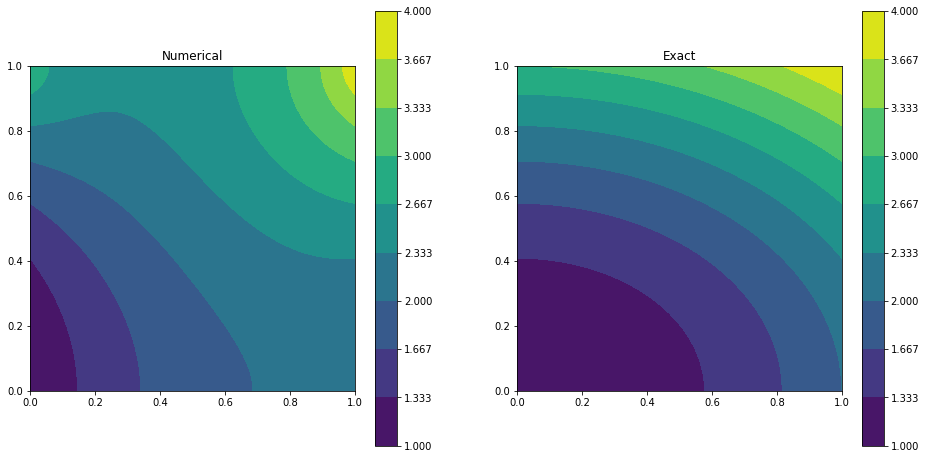

In [ ]:
fig, (ax, ax_donm) = plt.subplots(1, 2)
fig.set_size_inches(16, 8)

lis = [
    [uS, ax, 'Numerical'],
    [uEx, ax_donm, 'Exact'],
    ]

graph2D(
    fig=fig,
    lists=lis,
    natural_show=False,
    )